In [4]:
import sys
import os

import time
import cv2 as cv
from imageio import imsave, imread, imwrite
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('model/')
from model import MyModel
from dataset import B,V,F, FilesIndex, Dataset, Pipeline, action, inbatch_parallel
from face_batch import CelebrityBatch, load_func
import json

import pylsh

In [5]:
model_path = 'model/'
model_name = 'model-20170512-110547'
checkpoint_path = 'model-20170512-110547.ckpt-250000'
src_images = '../img_align_celeba/'
IMG_SHAPE = (160, 160)

In [6]:
preprocess_ppl = (Pipeline()
     .load(src=src_images, fmt='image', components='images')
     .to_cv(src='images')
     .detect_face()
     .crop_from_bbox(margin=0.2, top_margin=2)
     .resize(IMG_SHAPE, fmt='cv')
     .to_rgb()
    )

In [7]:
init_model_ppl = (Pipeline()
                    .init_model('static', MyModel, model_name,
                                config={'load' : {'path' : model_path, 'graph': model_name + '.meta',
                                                  'checkpoint' : checkpoint_path}, 
                                        'build': False}))

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model/model-20170512-110547.ckpt-250000


In [8]:
predict_ppl = ((preprocess_ppl + init_model_ppl)
                .init_variable('predicted_embeddings', init_on_each_run=0)
                .init_variable('indices', init_on_each_run=0)
                .predict_model(model_name, fetches="embeddings:0",
                               feed_dict={'input:0' : B('images'), 'phase_train:0' : False},
                               save_to=B('embedding'), mode='w')
                .dump(dst='demo_embeddings.csv', fmt='csv', mode='a', components='embedding', header=False)
              )

In [9]:
params = (50, 64, 128)

In [10]:
index2 = pylsh.PyLSH(50, 64, 128)

In [11]:
index2.fill_data_from_files(planes_path=b'./diff/split.txt', hash_tables_dir_path=b'./diff/index/',
                           index_embedding_dict_path=b'./diff/index_embedding.txt')

True

In [12]:
test_images = src_images
fileindex = FilesIndex(path=test_images+'*.jpg', no_ext=True)
test_set = Dataset(fileindex, batch_class=CelebrityBatch)

In [13]:
test_set.indices

array(['003634', '134385', '123420', ..., '128511', '196720', '056440'],
      dtype='<U30')

In [14]:
search_celebs_ppl = (predict_ppl
                      .find_nearest_neighbours(pyindex=index2, k_neighbours=10,
                                                        use_pylsh=True,
                                                        pylsh_params=params, use_preloaded=True)
#                       .load_dummy_neighbours(k_neighbours=10)
                    ) << test_set

In [15]:
start = time.clock()
btch = search_celebs_ppl.next_batch(10, n_epochs=None)
print(time.clock() - start)

HEEY [13967, 165314, 5537, 22550, 194296, 125158, 50679, 125802, 75238, 10323]
HEEY [162721, 65404, 115803, 135835, 64223, 69068, 139832, 25143, 126696, 96130]
HEEY [28279, 20911, 76884, 32628, 40146, 105404, 15274, 64134, 56905, 37030]
HEEY [87756, 114315, 33777, 72266, 47479, 156173, 78176, 152376, 91041, 195886]
HEEY [136151, 65704, 154005, 6710, 6876, 17349, 120506, 4054, 193895, 121465]
HEEY [7438, 138400, 20454, 114897, 195740, 82091, 58679, 3762, 97807, 15020]
HEEY [144435, 129773, 65038, 47011, 66630, 177816, 155442, 103349, 28181, 53837]
HEEY [126591, 128173, 26495, 66307, 175152, 58215, 108764, 55228, 86297, 194781]
HEEY [134496, 68092, 75518, 90212, 34832, 71075, 143717, 154640, 14443, 111867]
HEEY [25173, 144689, 170276, 20736, 41705, 71918, 79965, 40706, 131907, 70654]
9.023762000000005


In [39]:
test_images = 'custom_test/'
fileindex = FilesIndex(path=test_images+'*.jpeg', no_ext=True)
test_set = Dataset(fileindex, batch_class=CelebrityBatch)

In [40]:
test_set.indices

array(['1'], dtype='<U18')

In [44]:
search_celebs_ppl = (predict_ppl
                      .find_nearest_neighbours(pyindex=index2, k_neighbours=10,
                                                        use_pylsh=True,
                                                        pylsh_params=params, use_preloaded=True)
#                       .load_dummy_neighbours(k_neighbours=10)
                    ) << test_set

In [45]:
start = time.clock()
btch = search_celebs_ppl.next_batch(1, n_epochs=None)
print(time.clock() - start)

HEEY [45414, 135680, 201436, 202211, 104092, 97884, 28928, 195191, 186298, 75637]
0.9017200000000116


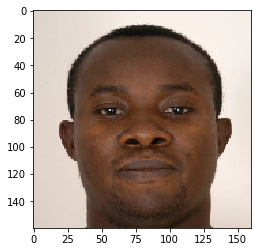

original


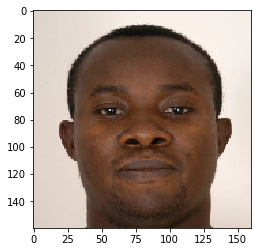

cols 10
created fig ax
neighbour 45414
neighbour 135680
neighbour 201436
neighbour 202211
neighbour 104092
neighbour 97884
neighbour 28928
neighbour 195191
neighbour 186298
neighbour 75637


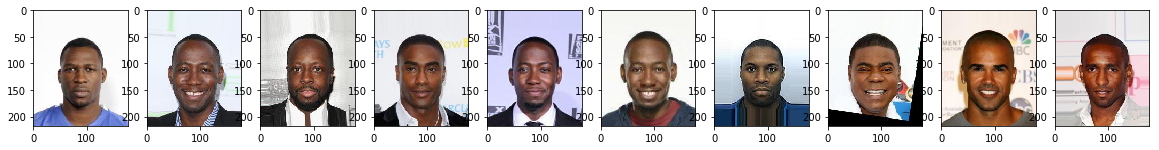

In [49]:
j = 0
print('original')
plt.imshow(btch.images[0])
plt.show()
cols = len(btch.neighbours[j])
print('cols', cols)
if cols > 1:
    fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(20, 120))
#         fig2, ax2 = plt.subplots(nrows=1, ncols=cols, figsize=(20, 120))

    print('created fig ax')
for i, neighbour_index in enumerate(btch.neighbours[j]):
    file_name = neighbour_index
#         dummy_filename = btch.dummy_neighbours[j][i]
    print('neighbour', file_name)
    name = ('000000' + str(file_name))[-6:] 
    pic = imread('../img_align_celeba/' + str(name) + '.jpg')
#         pic2 = imread('../cropped_photos/' + str(dummy_filename) + '.jpg')

    if cols > 1:
        ax[i].imshow(pic)
#             ax2[i].imshow(pic2)

    else:
        plt.imshow(pic)
        plt.show()
#             plt.imshow(pic2)
#             plt.show()

#     print('dummy:', btch.dummy_neighbours[j])
#     print('IOU ', len(set(btch.dummy_neighbours[j]) & set(btch.neighbours[j])) / 
#           10)
if cols == 0:
    print('______________')

plt.show()


In [19]:
start = time.clock()
btch = search_celebs_ppl.next_batch(10, n_epochs=None)
print(time.clock() - start)

HEEY [174066, 53965, 59443, 10748, 179927, 69143, 26439, 164876, 121266, 98084]
HEEY [182429, 71383, 109247, 130361, 118522, 137609, 115286, 58068, 123134, 53877]
HEEY [195675, 82807, 96869, 19960, 86615, 42790, 110991, 31962, 178280, 48987]
HEEY [77651, 189675, 64627, 156395, 139653, 102353, 101859, 176673, 143063, 177424]
HEEY [185912, 6990, 189559, 126828, 65039, 86024, 40794, 44493, 197851, 32131]
HEEY [108964, 185010, 68469, 111120, 17048, 82343, 97914, 132427, 96672, 201691]
HEEY [118070, 187499, 127458, 5178, 118514, 69637, 95548, 97808, 87676, 191312]
HEEY [194337, 124152, 199892, 83572, 38591, 136364, 190117, 3637, 50840, 93240]
HEEY [187639, 11154, 108782, 45571, 107307, 112595, 168, 33064, 160987, 112211]
HEEY [128406, 85443, 162143, 201966, 3666, 66264, 131083, 38331, 53074, 53940]
6.811210000000017


original


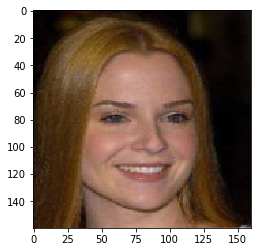

K is  10
cols 10
created fig ax
neighbour 31817
neighbour 169861
neighbour 130819
neighbour 25516
neighbour 188135
neighbour 97306
neighbour 106572
neighbour 119189
neighbour 186369
neighbour 114353


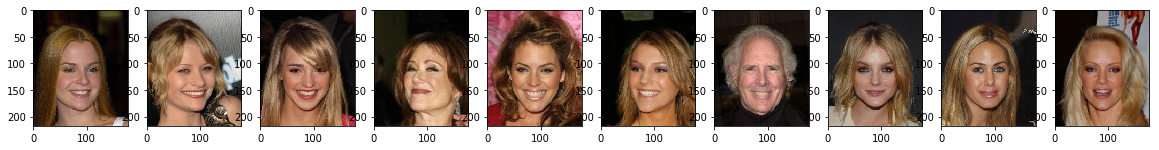

original


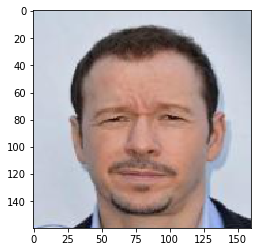

K is  10
cols 10
created fig ax
neighbour 135776
neighbour 72553
neighbour 139366
neighbour 11849
neighbour 81953
neighbour 146798
neighbour 159422
neighbour 43137
neighbour 145997
neighbour 1217


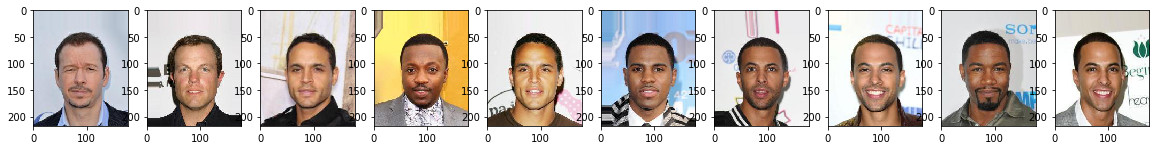

original


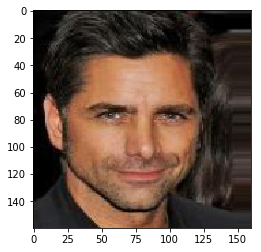

K is  10
cols 10
created fig ax
neighbour 11183
neighbour 27752
neighbour 158865
neighbour 69751
neighbour 97082
neighbour 96637
neighbour 174994
neighbour 131611
neighbour 196256
neighbour 145735


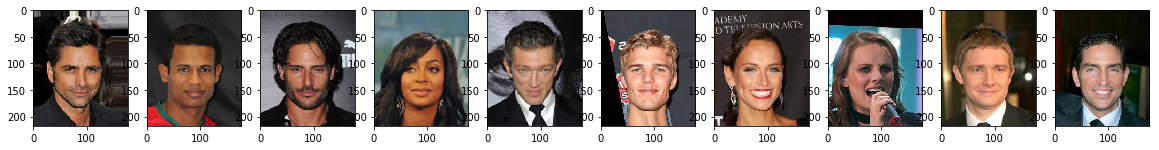

original


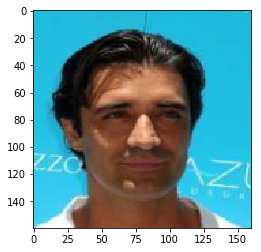

K is  10
cols 10
created fig ax
neighbour 178278
neighbour 112217
neighbour 55350
neighbour 106672
neighbour 26039
neighbour 96914
neighbour 169950
neighbour 182434
neighbour 38734
neighbour 153011


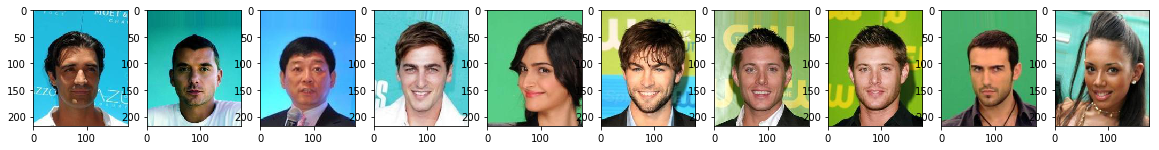

original


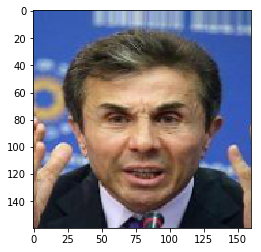

K is  10
cols 10
created fig ax
neighbour 49625
neighbour 142465
neighbour 147046
neighbour 151247
neighbour 99197
neighbour 69003
neighbour 160751
neighbour 140192
neighbour 145463
neighbour 73532


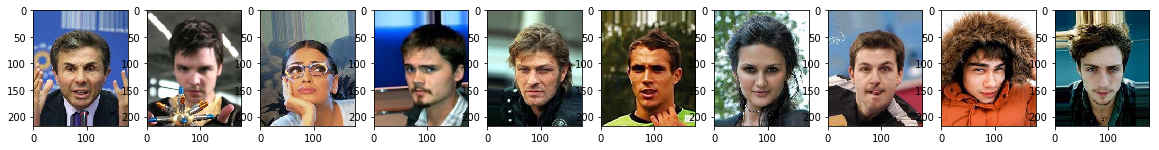

original


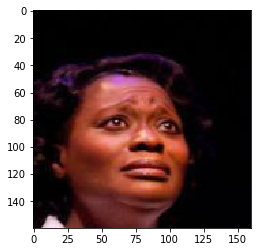

K is  10
cols 10
created fig ax
neighbour 107826
neighbour 56587
neighbour 172138
neighbour 39262
neighbour 81467
neighbour 88520
neighbour 34947
neighbour 32944
neighbour 11687
neighbour 172792


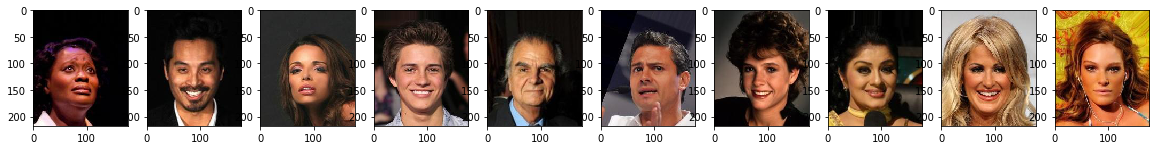

original


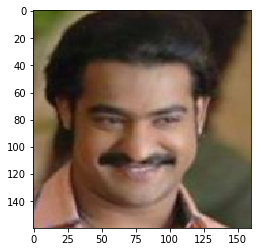

K is  10
cols 10
created fig ax
neighbour 15005
neighbour 180969
neighbour 63770
neighbour 49331
neighbour 109941
neighbour 111425
neighbour 90570
neighbour 95269
neighbour 124679
neighbour 9084


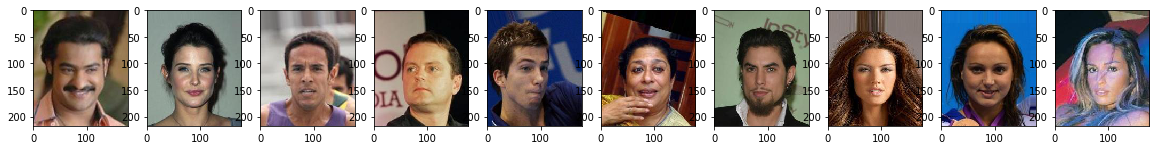

original


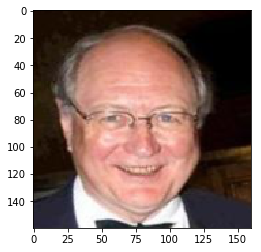

K is  10
cols 10
created fig ax
neighbour 118753
neighbour 95225
neighbour 121093
neighbour 49626
neighbour 125139
neighbour 139065
neighbour 55295
neighbour 131122
neighbour 58601
neighbour 51119


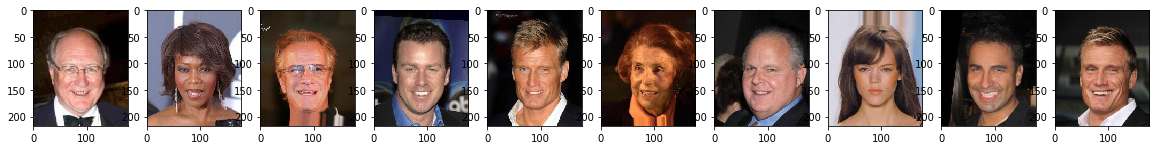

original


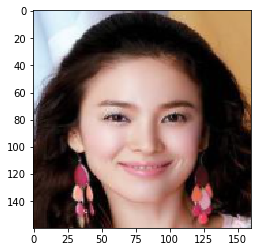

K is  10
cols 10
created fig ax
neighbour 139573
neighbour 41978
neighbour 157952
neighbour 192337
neighbour 131057
neighbour 133928
neighbour 151683
neighbour 86903
neighbour 118419
neighbour 47794


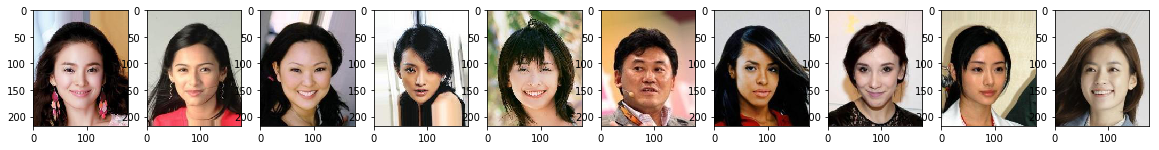

original


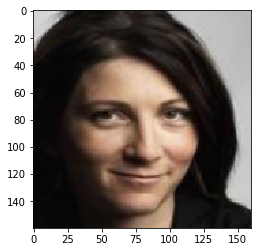

K is  10
cols 10
created fig ax
neighbour 53270
neighbour 66834
neighbour 175970
neighbour 36243
neighbour 75812
neighbour 66477
neighbour 88782
neighbour 145462
neighbour 99782
neighbour 39718


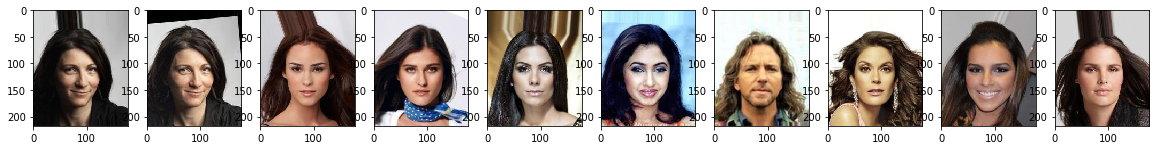

In [17]:
for j in range(len(btch.indices)):
    print('original')
    pic = btch.images[j]
    plt.imshow(pic)
    plt.show()
    print('K is ', len(btch.neighbours[j]))
    cols = len(btch.neighbours[j])
    print('cols', cols)
    if cols > 1:
        fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(20, 120))
#         fig2, ax2 = plt.subplots(nrows=1, ncols=cols, figsize=(20, 120))

        print('created fig ax')
    for i, neighbour_index in enumerate(btch.neighbours[j]):
        file_name = neighbour_index
#         dummy_filename = btch.dummy_neighbours[j][i]
        print('neighbour', file_name)
        name = ('000000' + str(file_name))[-6:] 
        pic = imread('../img_align_celeba/' + str(name) + '.jpg')
#         pic2 = imread('../cropped_photos/' + str(dummy_filename) + '.jpg')
        
        if cols > 1:
            ax[i].imshow(pic)
#             ax2[i].imshow(pic2)

        else:
            plt.imshow(pic)
            plt.show()
#             plt.imshow(pic2)
#             plt.show()

#     print('dummy:', btch.dummy_neighbours[j])
#     print('IOU ', len(set(btch.dummy_neighbours[j]) & set(btch.neighbours[j])) / 
#           10)
    if cols == 0:
        print('______________')

    plt.show()
    

original


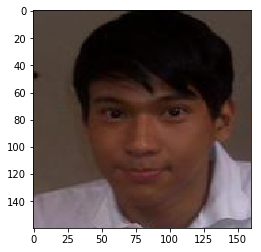

K is  10
cols 10
created fig ax
neighbour 174066
neighbour 53965
neighbour 59443
neighbour 10748
neighbour 179927
neighbour 69143
neighbour 26439
neighbour 164876
neighbour 121266
neighbour 98084


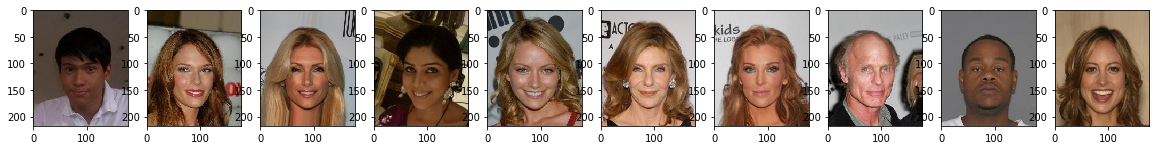

original


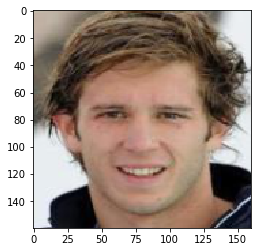

K is  10
cols 10
created fig ax
neighbour 182429
neighbour 71383
neighbour 109247
neighbour 130361
neighbour 118522
neighbour 137609
neighbour 115286
neighbour 58068
neighbour 123134
neighbour 53877


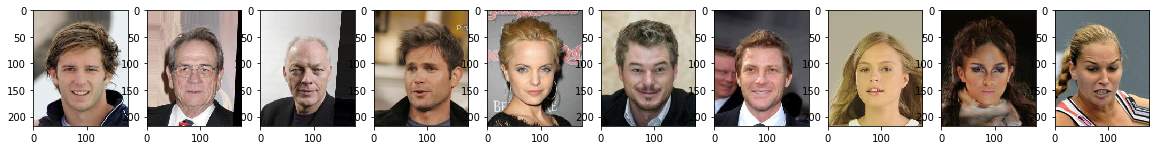

original


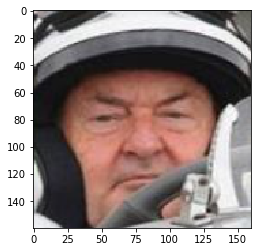

K is  10
cols 10
created fig ax
neighbour 195675
neighbour 82807
neighbour 96869
neighbour 19960
neighbour 86615
neighbour 42790
neighbour 110991
neighbour 31962
neighbour 178280
neighbour 48987


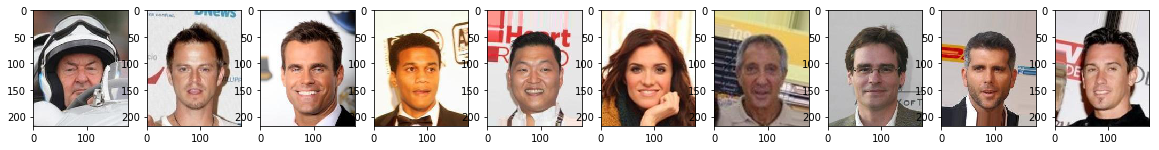

original


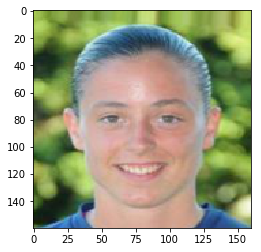

K is  10
cols 10
created fig ax
neighbour 77651
neighbour 189675
neighbour 64627
neighbour 156395
neighbour 139653
neighbour 102353
neighbour 101859
neighbour 176673
neighbour 143063
neighbour 177424


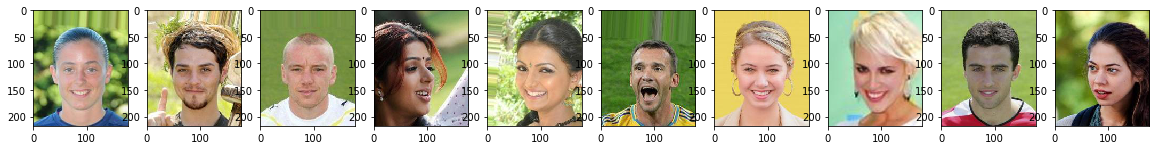

original


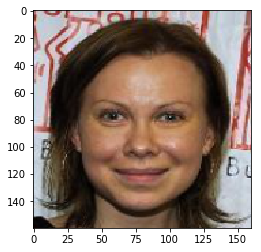

K is  10
cols 10
created fig ax
neighbour 185912
neighbour 6990
neighbour 189559
neighbour 126828
neighbour 65039
neighbour 86024
neighbour 40794
neighbour 44493
neighbour 197851
neighbour 32131


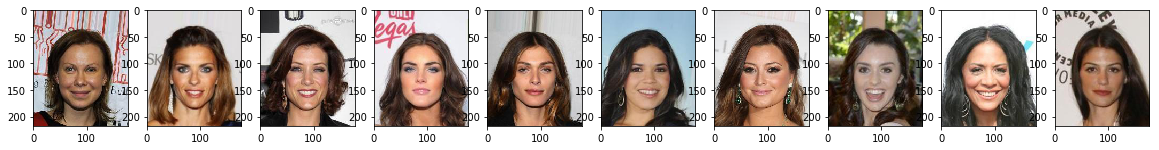

original


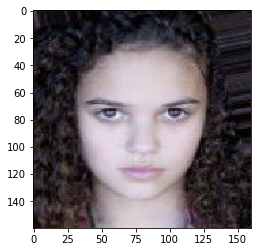

K is  10
cols 10
created fig ax
neighbour 108964
neighbour 185010
neighbour 68469
neighbour 111120
neighbour 17048
neighbour 82343
neighbour 97914
neighbour 132427
neighbour 96672
neighbour 201691


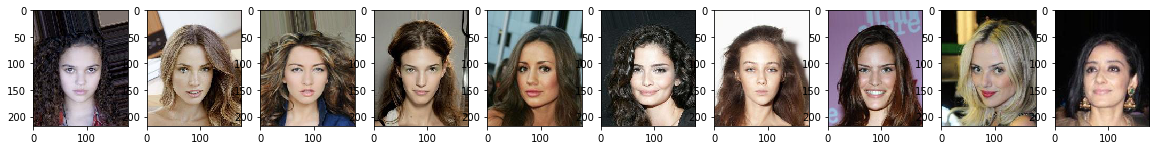

original


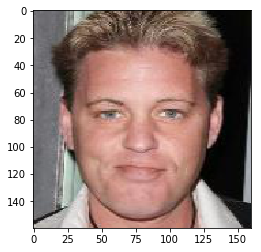

K is  10
cols 10
created fig ax
neighbour 118070
neighbour 187499
neighbour 127458
neighbour 5178
neighbour 118514
neighbour 69637
neighbour 95548
neighbour 97808
neighbour 87676
neighbour 191312


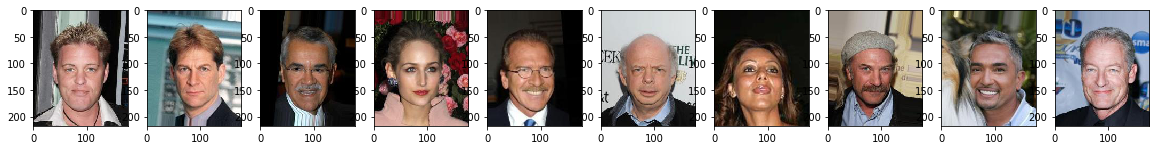

original


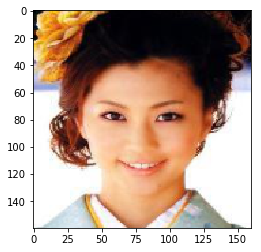

K is  10
cols 10
created fig ax
neighbour 194337
neighbour 124152
neighbour 199892
neighbour 83572
neighbour 38591
neighbour 136364
neighbour 190117
neighbour 3637
neighbour 50840
neighbour 93240


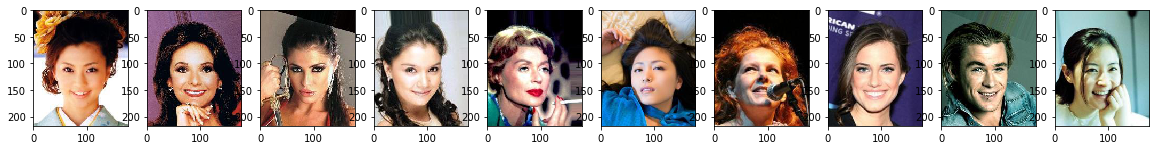

original


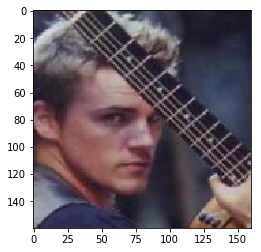

K is  10
cols 10
created fig ax
neighbour 187639
neighbour 11154
neighbour 108782
neighbour 45571
neighbour 107307
neighbour 112595
neighbour 168
neighbour 33064
neighbour 160987
neighbour 112211


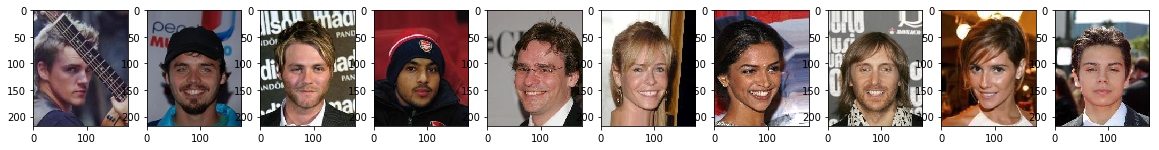

original


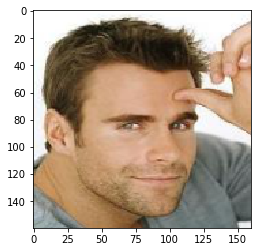

K is  10
cols 10
created fig ax
neighbour 128406
neighbour 85443
neighbour 162143
neighbour 201966
neighbour 3666
neighbour 66264
neighbour 131083
neighbour 38331
neighbour 53074
neighbour 53940


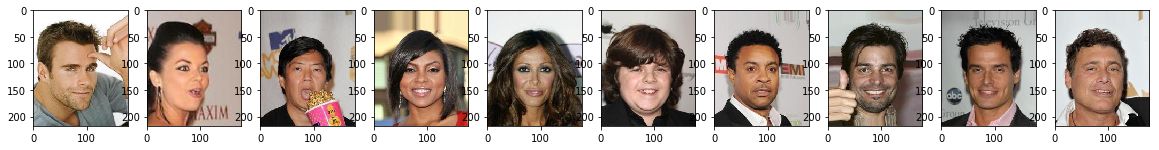

In [20]:
for j in range(len(btch.indices)):
    print('original')
    pic = btch.images[j]
    plt.imshow(pic)
    plt.show()
    print('K is ', len(btch.neighbours[j]))
    cols = len(btch.neighbours[j])
    print('cols', cols)
    if cols > 1:
        fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(20, 120))
#         fig2, ax2 = plt.subplots(nrows=1, ncols=cols, figsize=(20, 120))

        print('created fig ax')
    for i, neighbour_index in enumerate(btch.neighbours[j]):
        file_name = neighbour_index
#         dummy_filename = btch.dummy_neighbours[j][i]
        print('neighbour', file_name)
        name = ('000000' + str(file_name))[-6:] 
        pic = imread('../img_align_celeba/' + str(name) + '.jpg')
#         pic2 = imread('../cropped_photos/' + str(dummy_filename) + '.jpg')
        
        if cols > 1:
            ax[i].imshow(pic)
#             ax2[i].imshow(pic2)

        else:
            plt.imshow(pic)
            plt.show()
#             plt.imshow(pic2)
#             plt.show()

#     print('dummy:', btch.dummy_neighbours[j])
#     print('IOU ', len(set(btch.dummy_neighbours[j]) & set(btch.neighbours[j])) / 
#           10)
    if cols == 0:
        print('______________')

    plt.show()
    